# Optimization Techniques for Faster Training
- Multi-process Data Loading by increasing the number of worker in DataLoader.
- The use of pin_memory=True.
- Larger batch size.
- Utilizing all CPU cores by using torch.set_num_threads(num_threads).
- Just-In-Time (JIT) Compilation by using torch.jit.script.
- using torch.compile(model)

# Optimization Techniques for Faster Inference

- Dynamic quantization to reduce model weights from float32 to int8.
- JIT-Compiled to optimize.
- using torch.inference_mode(), it is faster than torch.no_grad() for inference by skipping gradient and version tracking.
- ONNX Export

In [18]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 77.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.2 MB/s eta 0:00:00


In [2]:
import torch
import os
import psutil

num_threads = os.cpu_count()
print(f"available cpu threads in this machine {num_threads}")
torch.set_num_threads(2)
print(f"{torch.get_num_threads()} CPU threads used by PyTorch.")

available cpu threads in this machine 4
2 CPU threads used by PyTorch.


In [3]:
num_workers = os.cpu_count()
print(f"available CPU cores (number of threads): {num_workers}")

print(f"number of CPU cores (physical cores): {psutil.cpu_count(logical=False)}")  # This gives physical cores
print(f"number of CPU threads: {psutil.cpu_count(logical=True)}")   # This gives logical(number of threads) cores (same as os.cpu_count())

available CPU cores (number of threads): 4
number of CPU cores (physical cores): 2
number of CPU threads: 4


In [4]:
import torch 
from torch import nn 
from torch.utils.data import DataLoader
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

<h2 style="background:#00373E; color: #E3EEFC; border-radius: 4px; padding: 8px 32px;"><a class="anchor"  id="2-2. data-preperation">1. Data Preparation</a></h2>

In [5]:
# load data
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv", dtype = np.float32)

# data spliting
features = train.loc[:, train.columns != "label"]
np_targets = train.label.values

# normalize features
np_features = features.values/255

In [6]:
train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


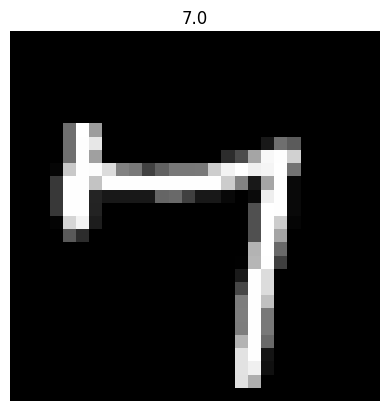

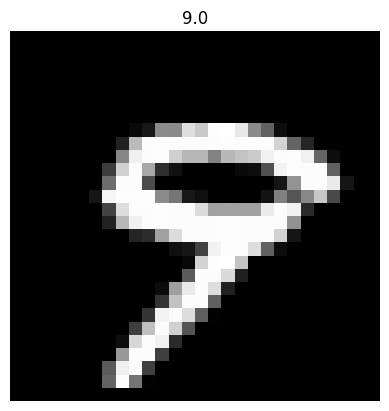

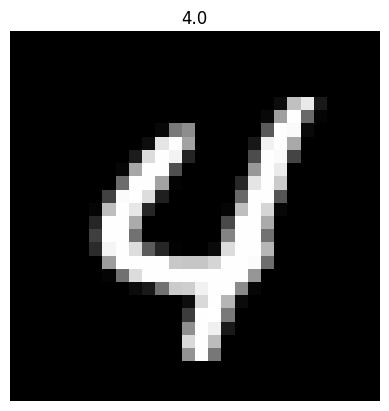

In [10]:
# Data visualization
images = [120, 121, 122]
for image in images:
    plt.imshow(np_features[image].reshape(28,28), cmap='gray')
    plt.axis("off")
    plt.title(str(np_targets[image]))
    plt.show()

In [11]:
# data split for train and testing 
x_train, x_test, y_train, y_test = train_test_split(np_features, np_targets, test_size=0.2, random_state=42)

# conversion from numpy and tensor
x_train = torch.from_numpy(x_train).type(torch.float32)
x_test = torch.from_numpy(x_test).type(torch.float32)
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [12]:
# Creating PyTorch train and test datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

# define batch size for training and testing 

# to optimize performance for training:
# - num_workers
# - pin_memory=True

num_workers = 2

batch_size = 100
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

# train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

<h2 style="background:#00373E; color: #E3EEFC; border-radius: 4px; padding: 8px 32px;"><a class="anchor"  id="2-2. data-preperation">2. Building ANN Model</a></h2>

In [13]:
class ANNModel(nn.Module): 
    
    ### Define Network Architecture ###
    def __init__(self, input_dim, hidden_dim, output_dim):
        
        super(ANNModel, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.act1 = nn.ReLU() # Activation function
        
        self.layer2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.act2 = nn.ReLU()
        
        self.layer3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.act3 = nn.ReLU() 
        
        self.layer4 = nn.Linear(hidden_dim // 4, output_dim)
        
    ### Define Forward Pass ###
    def forward(self, x): 
        
       
        out = self.layer1(x)
        out = self.act1(out)

        out = self.layer2(out)
        out = self.act2(out)
        
        out = self.layer3(out)
        out = self.act3(out)
    
        out = self.layer4(out)
        
        
        return out

In [14]:
# set the parameters
input_dim = 28*28 # the size of the image
hidden_dim = 160 # open for experiment but 150 as a start
output_dim = 10 # number of classes (from 0 to 9)

batch_size = 100
# it requires 10000 batches to 
n_iterations = 2000
num_epochs = n_iterations / (len(x_train) / batch_size)
num_epochs = int(num_epochs)
print(f"number of epochs: {num_epochs}")

# # Create the model
# model = ANNModel(input_dim, hidden_dim, output_dim)


# ### Set loss, optimizer, and Learning rate ###

# # loss function -> CrossEnropy (check pytorch docs)
# error = nn.CrossEntropyLoss() 

# # Learning rate 
# learning_rate = 0.02 #(just as a start)

# # optimizer -> Stochastic gradient decent (SGD)
# optim = torch.optim.Adam(model.parameters(),
#                        lr= learning_rate)

number of epochs: 5


<h2 style="background:#00373E; color: #E3EEFC; border-radius: 4px; padding: 8px 32px;"><a class="anchor"  id="2-2. data-preperation">3. Model Training</a></h2>

In [16]:
### Model training loop ###

import torch.profiler as profiler

# Prepare for tracking
model_loss = []
model_accuracy = []

# Set device explicitly to CPU
device = torch.device("cpu")

# --- Integrate the PyTorch Profiler ---
with profiler.profile(
    activities=[
        profiler.ProfilerActivity.CPU,
        profiler.ProfilerActivity.CUDA if torch.cuda.is_available() else None,
    ],
    record_shapes=True,
    profile_memory=True,
    with_stack=True) as prof:


    # Create the model
    model = ANNModel(input_dim, hidden_dim, output_dim).to(device)

    # JIT compiled
    # model = torch.jit.script(model)
    # using compile
    # model = torch.compile(model, mode="reduce-overhead")  
    
    error = nn.CrossEntropyLoss() 
    learning_rate = 0.02 
    optim = torch.optim.Adam(model.parameters(), lr= learning_rate)

    # Start training
    for epoch in range(num_epochs): 
        model.train()

        running_loss = 0.0
        total_train = 0
        correct_train = 0

        for i, (images, labels) in enumerate(train_loader): 
            inputs = images.view(-1, 28*28)
            
            optim.zero_grad() 
            
            outputs = model(inputs)
            
            loss = error(outputs, labels)
            loss.backward() 
            optim.step()
            
            # Accumulate loss
            running_loss += loss.item()

            predicted = torch.max(outputs.data, 1)[1]
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Evaluate on test set after each epoch
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader: 
                test = images.view(-1, 28*28)
                outputs = model(test) 
                predicted = torch.max(outputs.data, 1)[1]
                total += labels.size(0) 
                correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / float(total)

        # Store and print per epoch
        model_loss.append(epoch_loss)
        model_accuracy.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} | Accuracy: {epoch_accuracy:.2f}%")
        
        prof.step()

# Print the profiler output

print("\n", "CPU's Performance Report")
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))


Epoch [1/5] Loss: 0.3463 | Accuracy: 93.51%
Epoch [2/5] Loss: 0.1970 | Accuracy: 94.69%
Epoch [3/5] Loss: 0.1732 | Accuracy: 94.71%
Epoch [4/5] Loss: 0.1610 | Accuracy: 93.50%
Epoch [5/5] Loss: 0.1585 | Accuracy: 95.55%

 CPU's Performance Report
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        33.58%        8.553s        33.88%        8.631s       4.090ms     629.65 Mb     628.05 Mb          2110  
                               Optimizer.step#Adam.step         9.49%    

<h2 style="background:#00373E; color: #E3EEFC; border-radius: 4px; padding: 8px 32px;"><a class="anchor"  id="2-2. data-preperation">4. Comparative Analysis of Techniques for Faster Inference</a></h2>

In [33]:
import time
import os
import torch
import torch.onnx
import torch.nn as nn
import numpy as np
import onnxruntime as ort
from onnxruntime.quantization import quantize_dynamic, QuantType

results = []

# ------------------------------
# Helper: File Size
# ------------------------------
def get_file_size(filename):
    size_mb = os.path.getsize(filename) / (1024 * 1024)
    print(f"📦 {filename} size: {size_mb:.2f} MB")
    return size_mb

# ------------------------------
# PyTorch Evaluation
# ------------------------------
def evaluate_model(model, name, save_path=None):
    model.eval()
    correct = 0
    total = 0
    start_time = time.time()

    with torch.inference_mode():
        for images, labels in test_loader:
            images = images.view(-1, 28 * 28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    end_time = time.time()
    acc = 100 * correct / total
    dur = end_time - start_time
    size = get_file_size(save_path) if save_path else 0
    results.append((name, acc, dur, size))
    print(f"⚡ {name} - Accuracy: {acc:.2f}% | Time: {dur:.2f} sec")

# ------------------------------
# ONNX Evaluation
# ------------------------------
def evaluate_onnx_model(path, name):
    session = ort.InferenceSession(path)
    correct, total = 0, 0
    start = time.time()

    for images, labels in test_loader:
        images = images.view(-1, 28 * 28).numpy().astype(np.float32)
        outputs = session.run(None, {"input": images})[0]
        predicted = np.argmax(outputs, axis=1)
        total += labels.size(0)
        correct += (predicted == labels.numpy()).sum().item()

    end = time.time()
    acc = 100 * correct / total
    dur = end - start
    size = get_file_size(path)
    results.append((name, acc, dur, size))
    print(f"⚡ {name} - Accuracy: {acc:.2f}% | Time: {dur:.2f} sec")



# ------------------------------
# 1. Save PyTorch Model (Optional)
# ------------------------------
torch.save(model.state_dict(), "model_fp32.pth")
evaluate_model(model, "FP32", "model_fp32.pth")

# ------------------------------
# 2. JIT Compile
# ------------------------------
jit_fp32 = torch.jit.script(model)
jit_fp32.save("model_fp32_jit.pt")
evaluate_model(jit_fp32, "JIT FP32", "model_fp32_jit.pt")

# ------------------------------
# 3. Dynamic Quantization + JIT
# ------------------------------
quantized = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
jit_quant = torch.jit.script(quantized)
jit_quant.save("model_quant_jit.pt")
evaluate_model(jit_quant, "JIT Quantized INT8", "model_quant_jit.pt")

# ------------------------------
# 4. Export to ONNX (FP32)
# ------------------------------
dummy_input = torch.randn(1, 28 * 28)
torch.onnx.export(
    model, dummy_input, "model_fp32.onnx",
    input_names=["input"], output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)
evaluate_onnx_model("model_fp32.onnx", "ONNX FP32")

# ------------------------------
# 5. ONNX Quantization (INT8)
# ------------------------------
quantize_dynamic("model_fp32.onnx", "model_quant.onnx", weight_type=QuantType.QInt8)
evaluate_onnx_model("model_quant.onnx", "ONNX Quantized INT8")

# ------------------------------
# 6. TorchDynamo + TorchInductor (PyTorch 2.x)
# ------------------------------
compiled_model = torch.compile(model, mode="default", backend="inductor")
evaluate_model(compiled_model, "Torch.compile FP32")

# ------------------------------
# 6. Summary Table
# ------------------------------
print("\n📊 Inference Summary:\n")
print("{:<25} {:>10} {:>15} {:>15}".format("Model", "Accuracy", "Time (sec)", "Size (MB)"))
print("-" * 70)
for name, acc, dur, size in results:
    print(f"{name:<25} {acc:10.2f} {dur:15.2f} {size:15.2f}")


📦 model_fp32.pth size: 0.55 MB
⚡ FP32 - Accuracy: 95.55% | Time: 1.10 sec
📦 model_fp32_jit.pt size: 0.55 MB
⚡ JIT FP32 - Accuracy: 95.55% | Time: 1.01 sec
📦 model_quant_jit.pt size: 0.15 MB
⚡ JIT Quantized INT8 - Accuracy: 95.60% | Time: 1.02 sec
📦 model_fp32.onnx size: 0.54 MB
⚡ ONNX FP32 - Accuracy: 95.55% | Time: 0.98 sec
📦 model_quant.onnx size: 0.14 MB
⚡ ONNX Quantized INT8 - Accuracy: 95.57% | Time: 0.96 sec
⚡ Torch.compile FP32 - Accuracy: 95.55% | Time: 1.04 sec

📊 Inference Summary:

Model                       Accuracy      Time (sec)       Size (MB)
----------------------------------------------------------------------
FP32                           95.55            1.10            0.55
JIT FP32                       95.55            1.01            0.55
JIT Quantized INT8             95.60            1.02            0.15
ONNX FP32                      95.55            0.98            0.54
ONNX Quantized INT8            95.57            0.96            0.14
Torch.compile FP3